In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [35]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img



def get_meerkat_image(sidelength):
  from astropy.io import fits
  import numpy as np
  filename = "/content/drive/MyDrive/Colab Notebooks/MeerKAT_Galactic_Centre_1284MHz-StokesI.fits"
  with fits.open(filename) as hdul:
      data = hdul[0].data[4500:4500+sidelength,4500:4500+sidelength].astype(np.float32)
  data = data-np.min(data)
  data+=1e-5
  data=np.log(data)
  data = data-np.min(data)
  data = data/np.max(data)
  img =  Image.fromarray(data)
  del data
  transform = Compose([
      Resize(sidelength),
      ToTensor(),
      Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
  ])
  img = transform(img)
  return img

In [37]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        #img = get_cameraman_tensor(sidelength)
        img = get_meerkat_image(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels


In [41]:
cameraman = ImageFitting(1500)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well.

Step 0, Total loss 0.015157


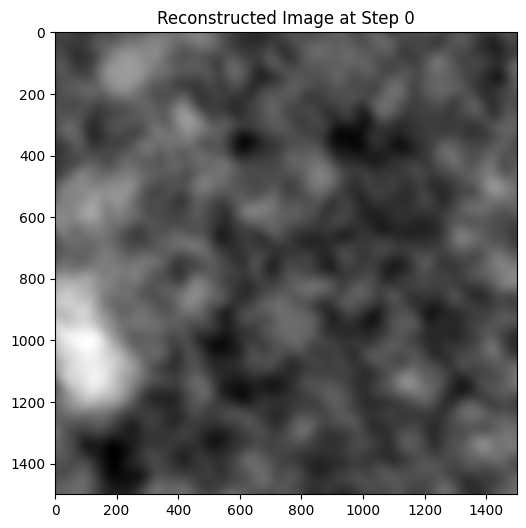

Step 10, Total loss 0.003474


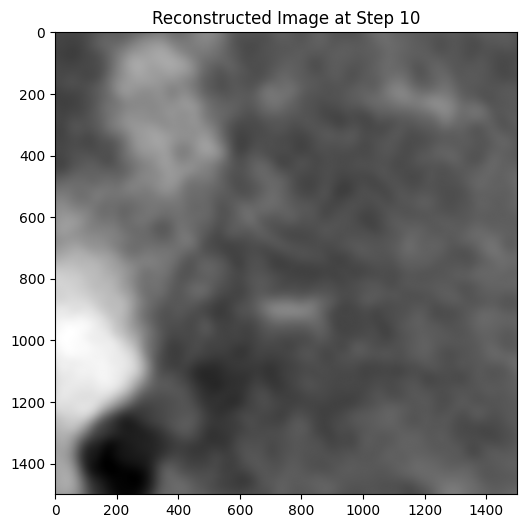

Step 20, Total loss 0.001669


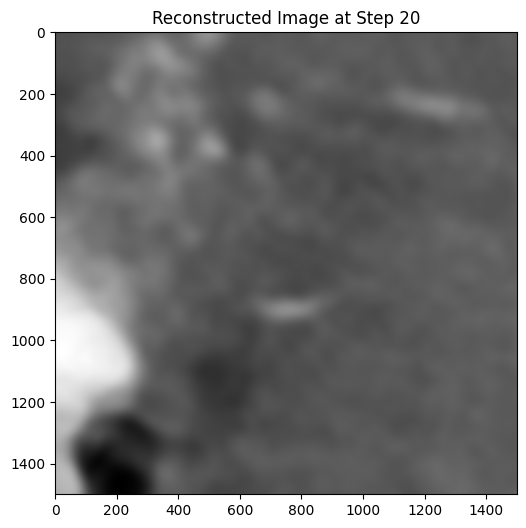

Step 30, Total loss 0.001229


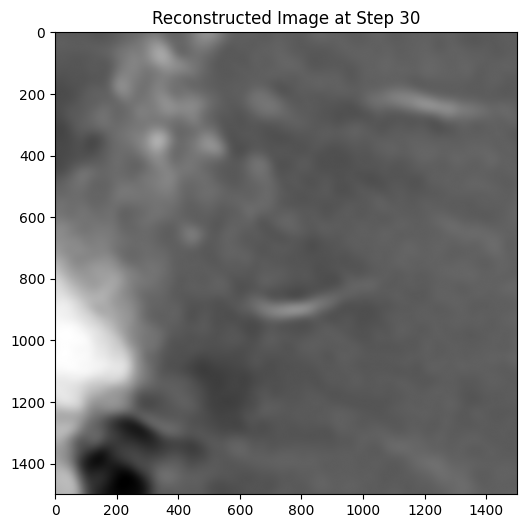

Step 40, Total loss 0.000992


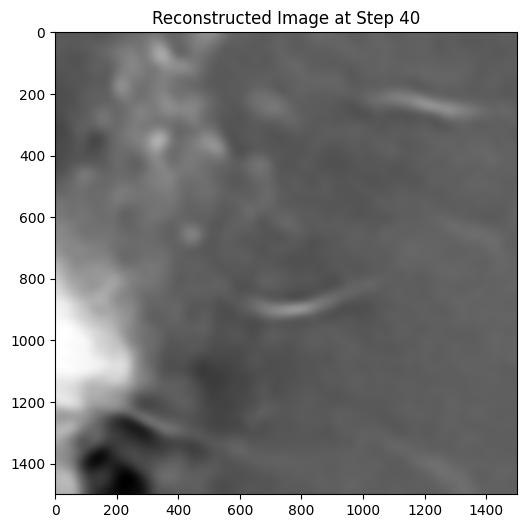

Step 50, Total loss 0.000860


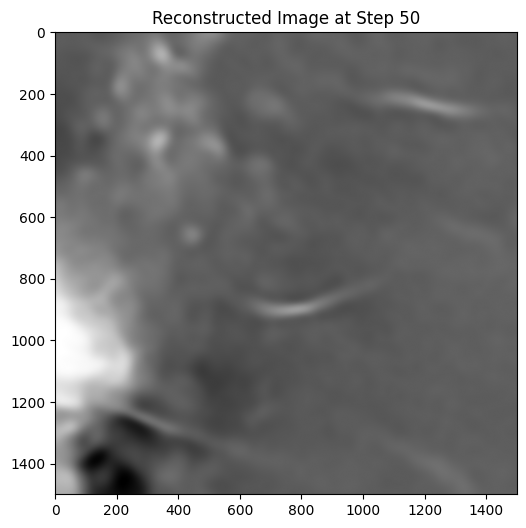

Step 60, Total loss 0.000775


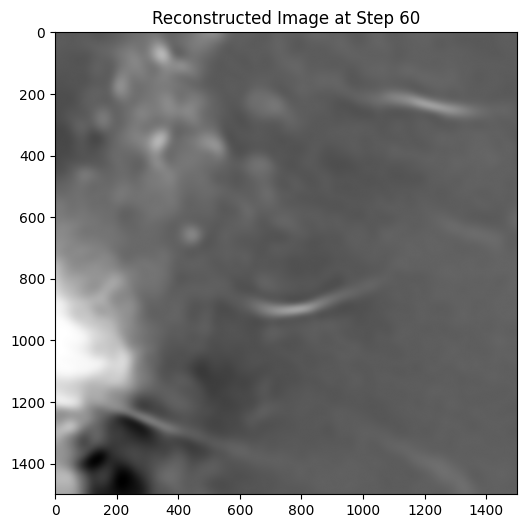

Step 70, Total loss 0.000713


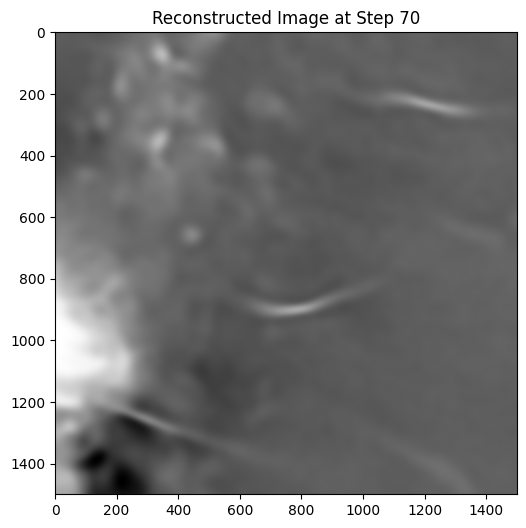

Step 80, Total loss 0.000663


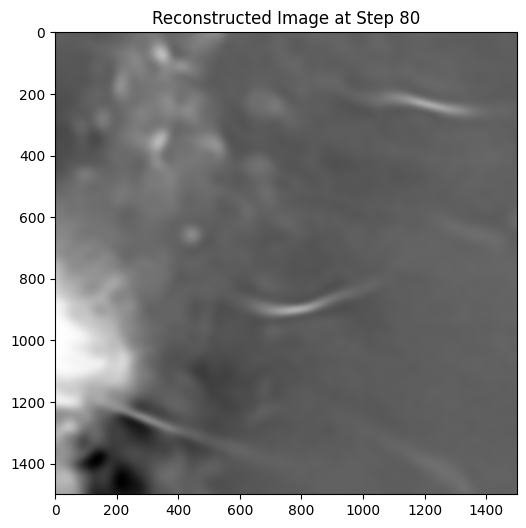

Step 90, Total loss 0.000623


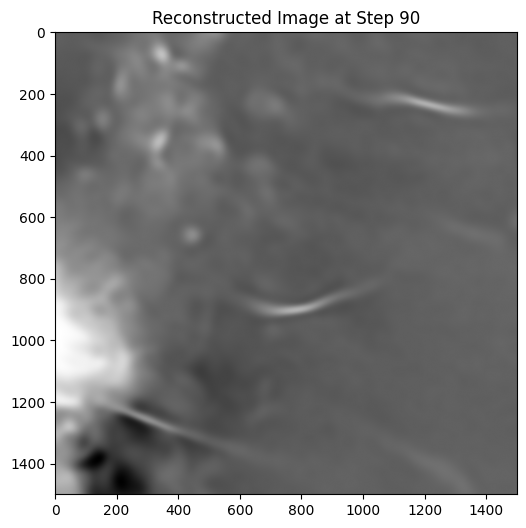

Step 100, Total loss 0.000590


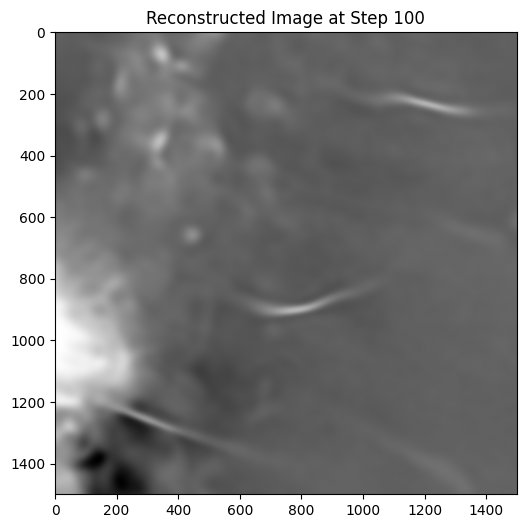

Step 110, Total loss 0.000563


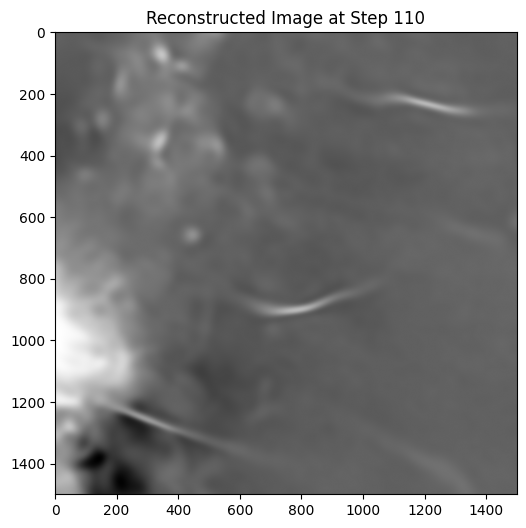

Step 120, Total loss 0.000540


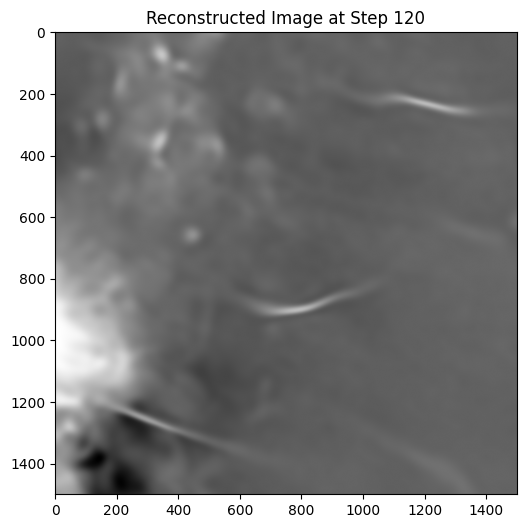

Step 130, Total loss 0.000520


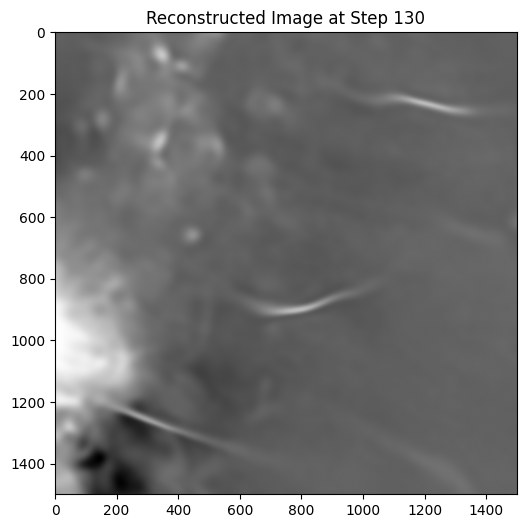

Step 140, Total loss 0.000503


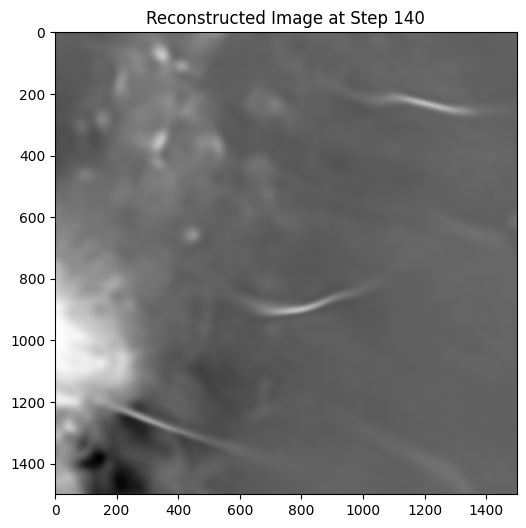

Step 150, Total loss 0.000488


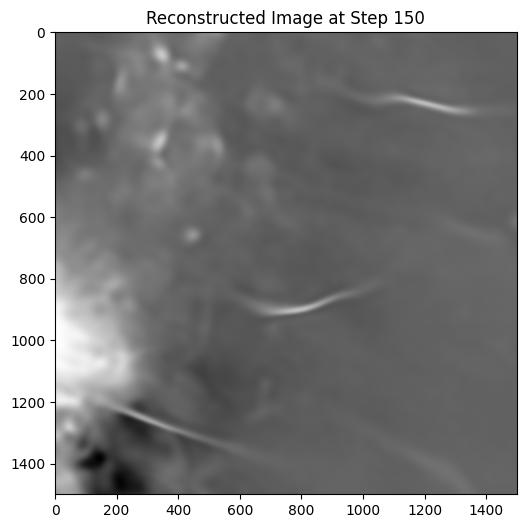

Step 160, Total loss 0.000474


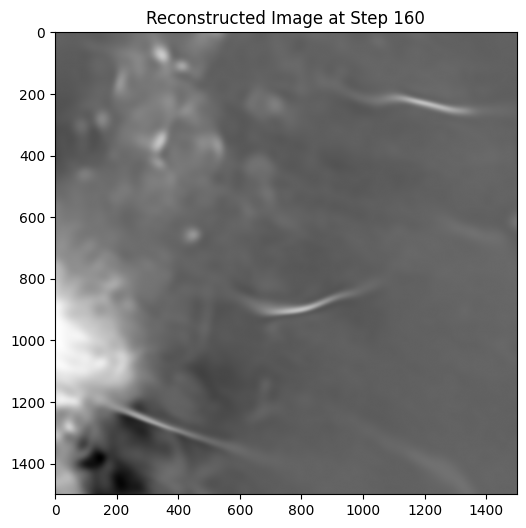

Step 170, Total loss 0.000461


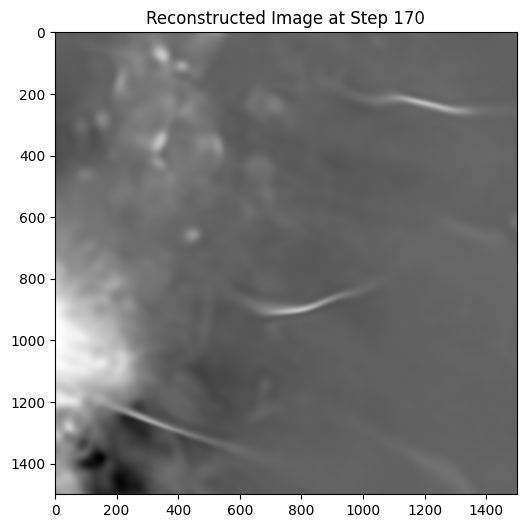

Step 180, Total loss 0.000450


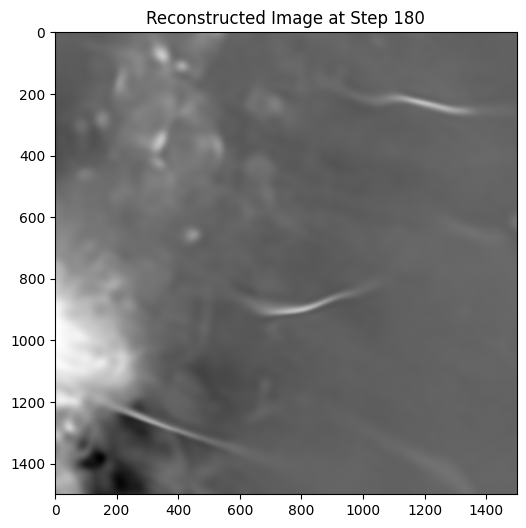

Step 190, Total loss 0.000439


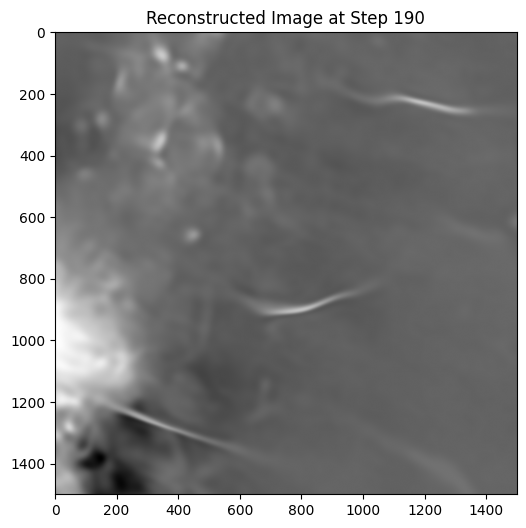

Step 200, Total loss 0.000429


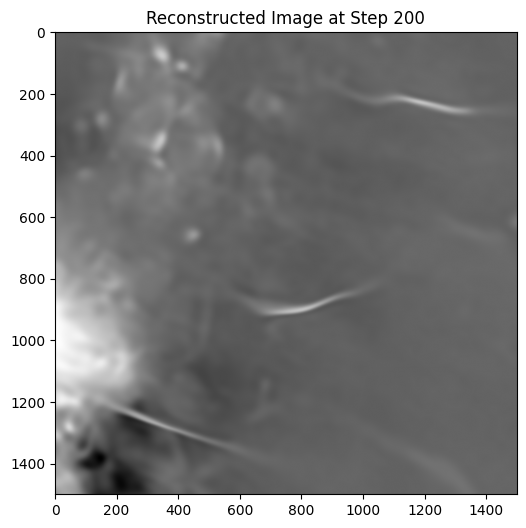

Step 210, Total loss 0.000420


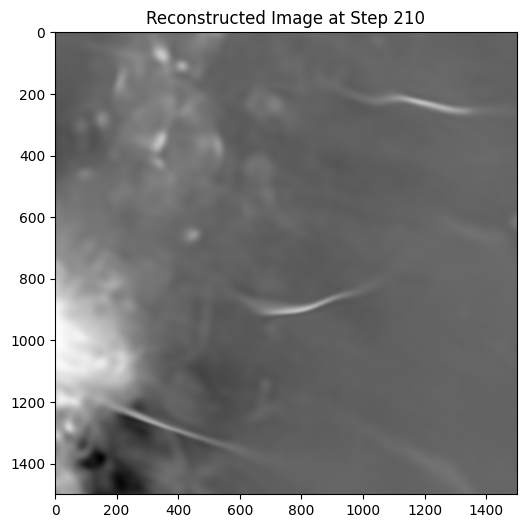

Step 220, Total loss 0.000412


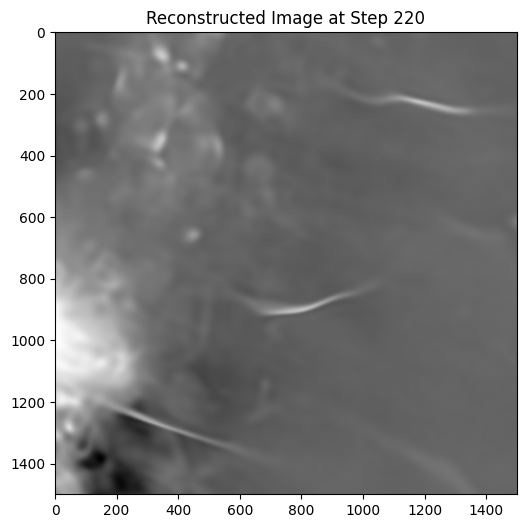

Step 230, Total loss 0.000404


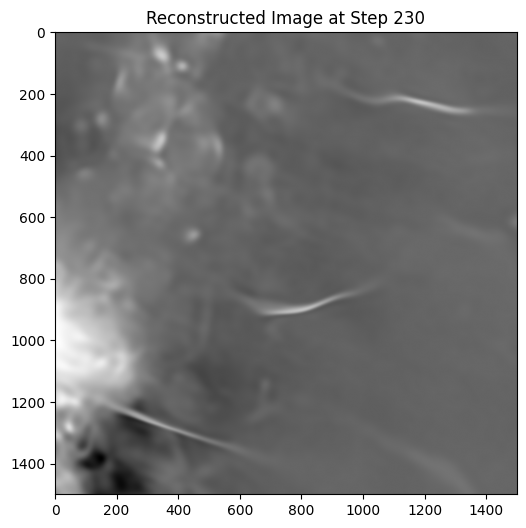

Step 240, Total loss 0.000396


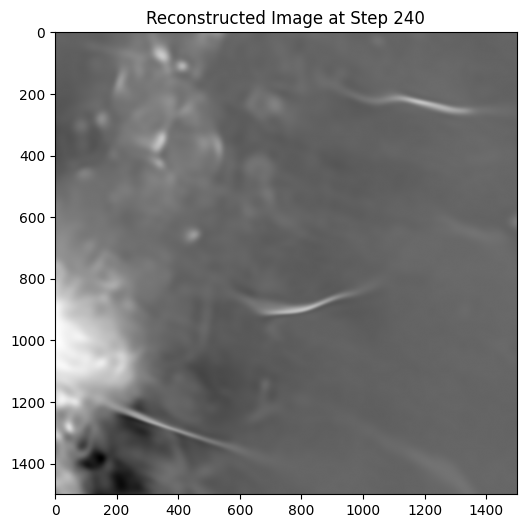

Step 250, Total loss 0.000389


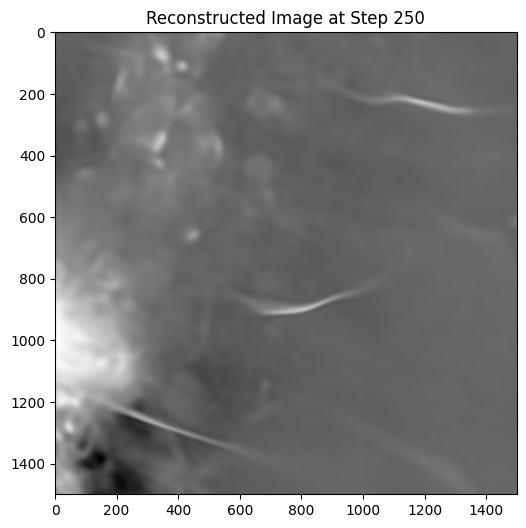

Step 260, Total loss 0.000382


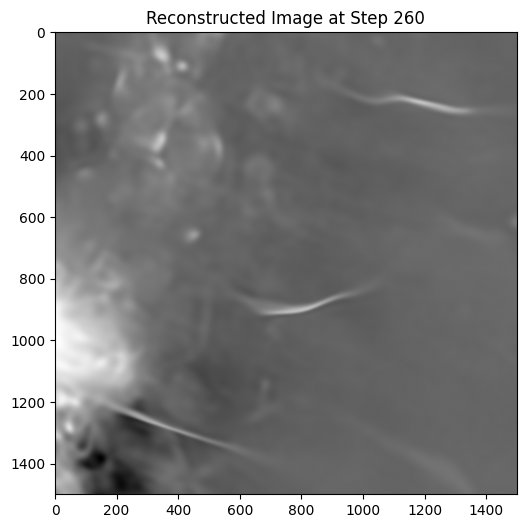

Step 270, Total loss 0.000376


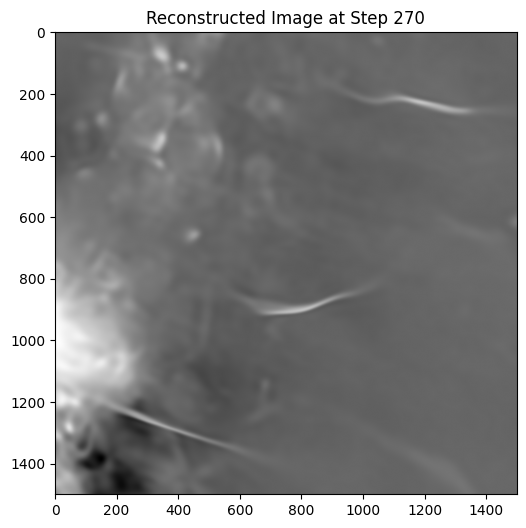

Step 280, Total loss 0.000370


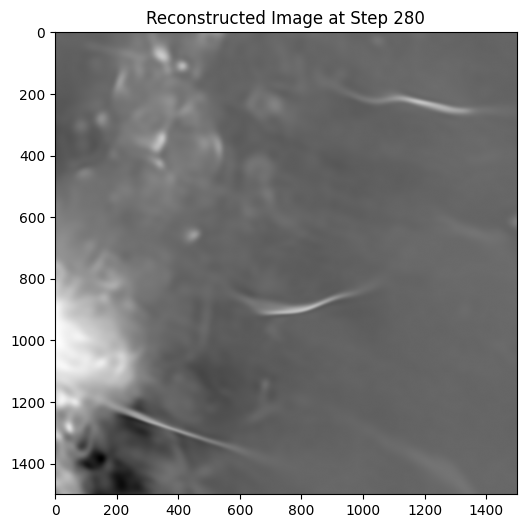

Step 290, Total loss 0.000364


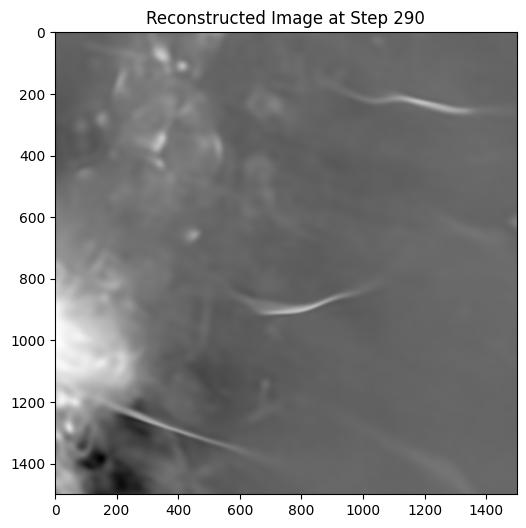

Step 300, Total loss 0.000359


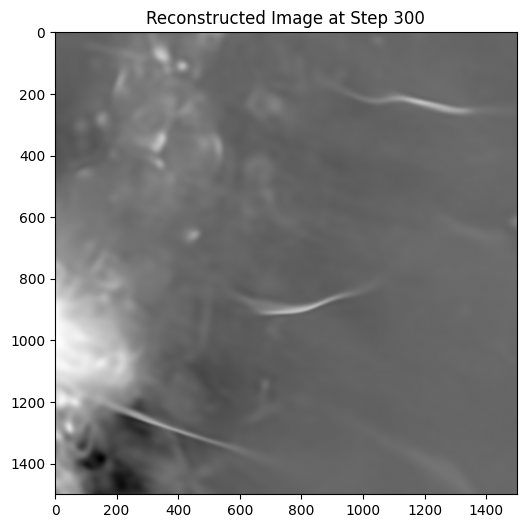

Step 310, Total loss 0.000353


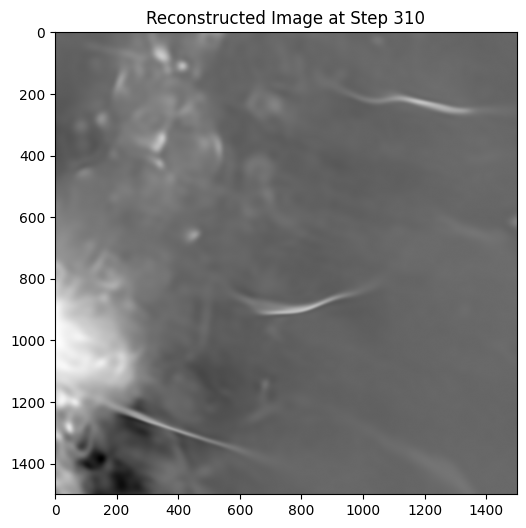

Step 320, Total loss 0.000348


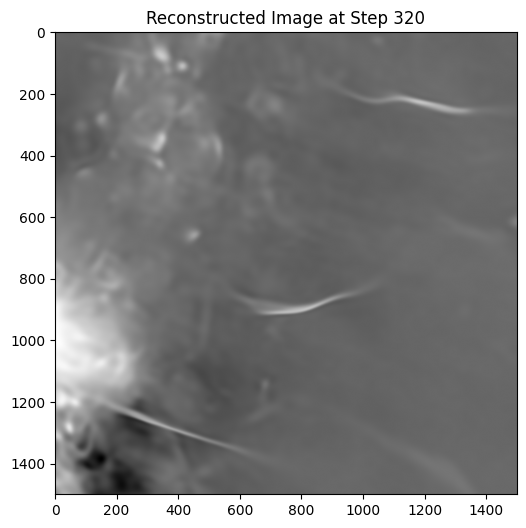

Step 330, Total loss 0.000343


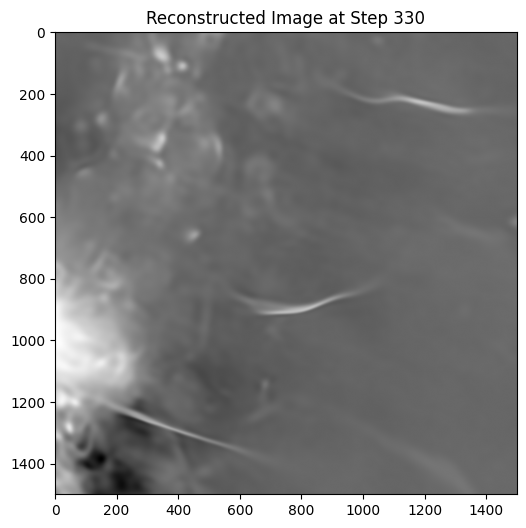

Step 340, Total loss 0.000338


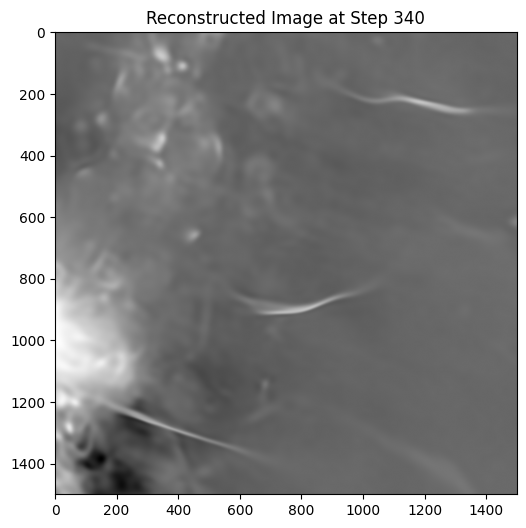

Step 350, Total loss 0.000334


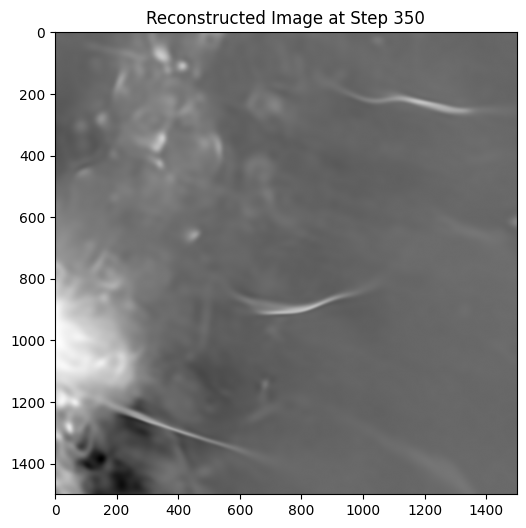

Step 360, Total loss 0.000329


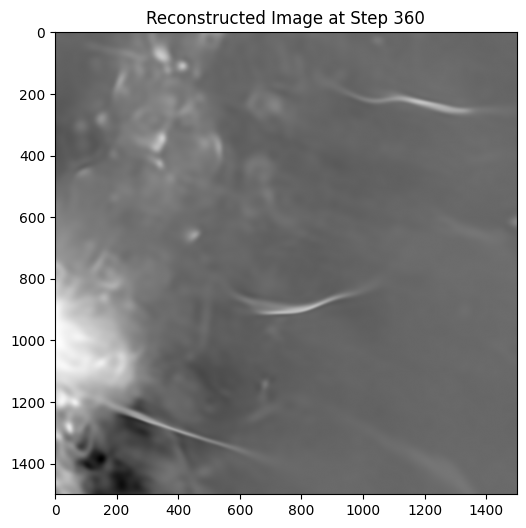

Step 370, Total loss 0.000325


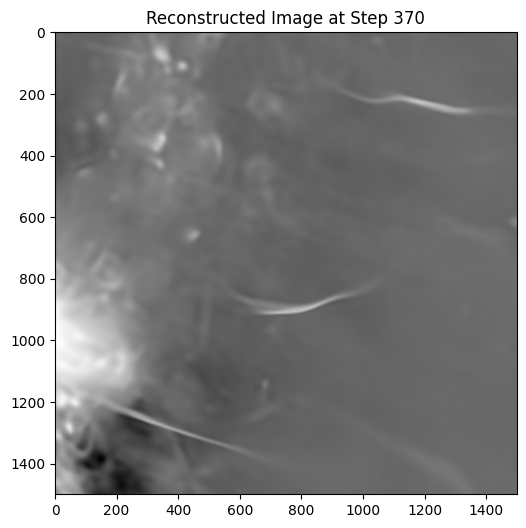

Step 380, Total loss 0.000320


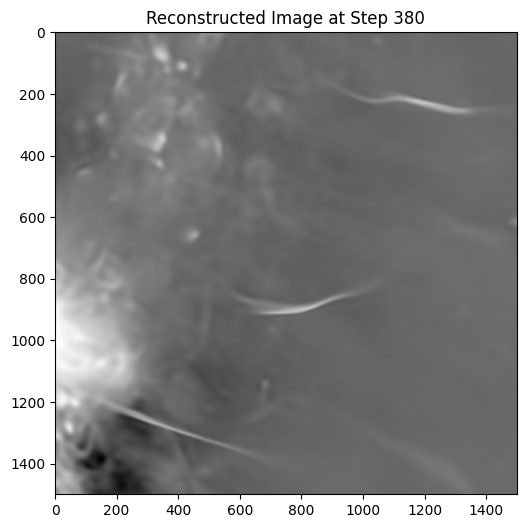

Step 390, Total loss 0.000316


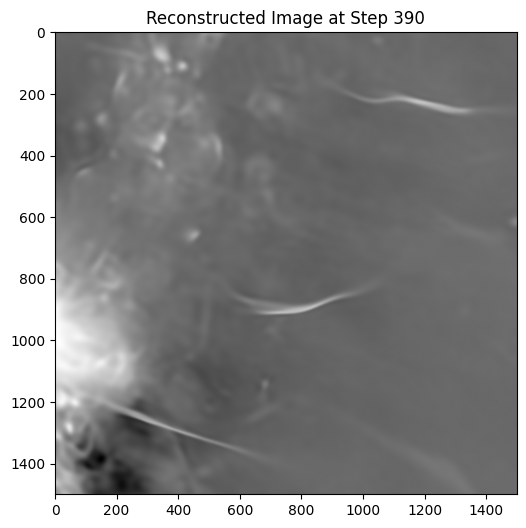

Step 400, Total loss 0.000312


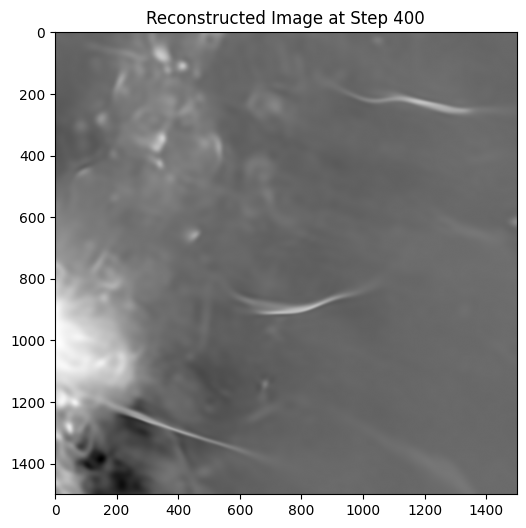

Step 410, Total loss 0.000308


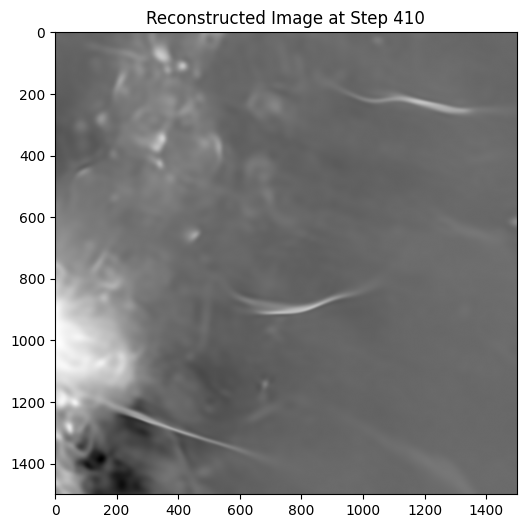

Step 420, Total loss 0.000304


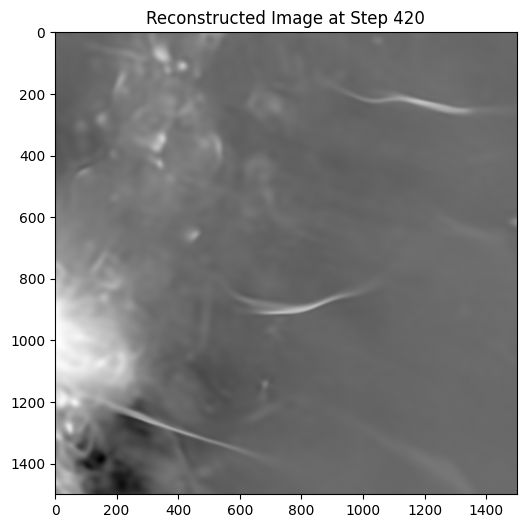

Step 430, Total loss 0.000300


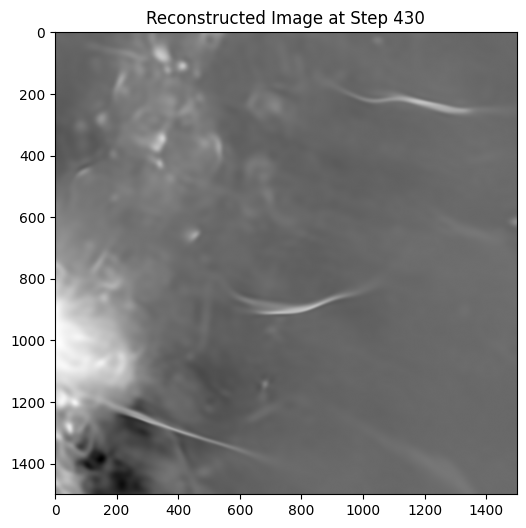

Step 440, Total loss 0.000296


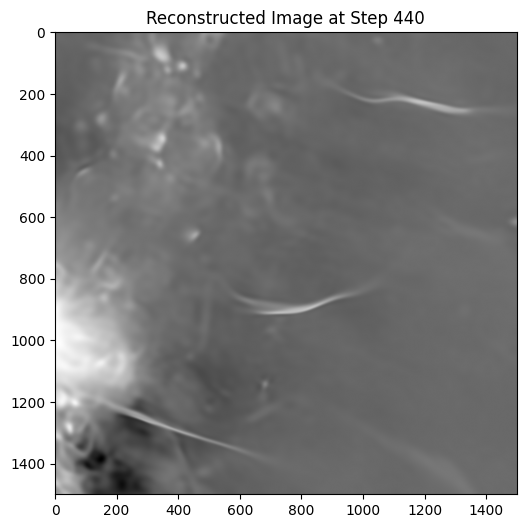

Step 450, Total loss 0.000292


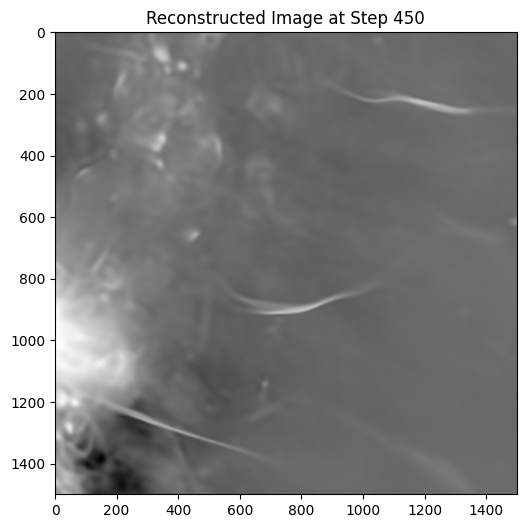

Step 460, Total loss 0.000288


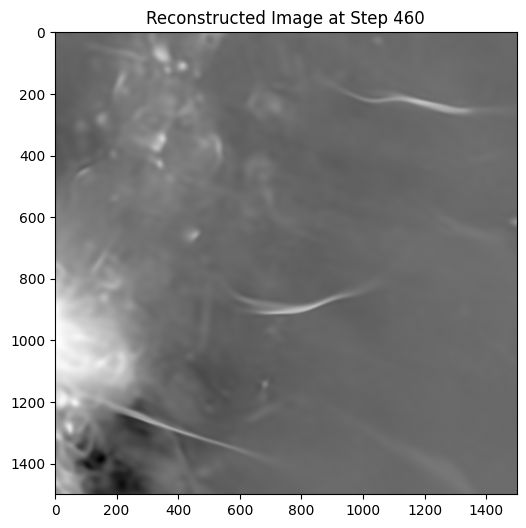

Step 470, Total loss 0.000284


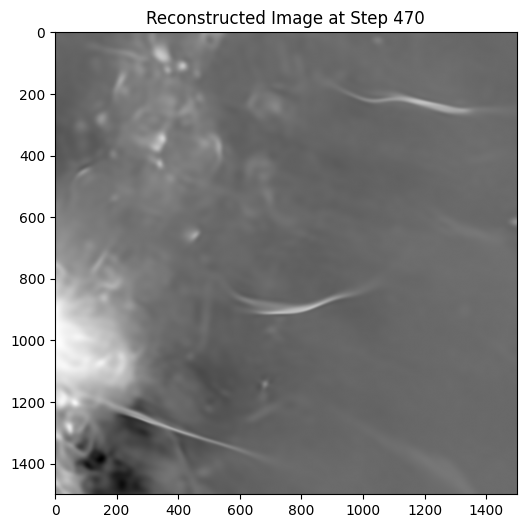

Step 480, Total loss 0.000281


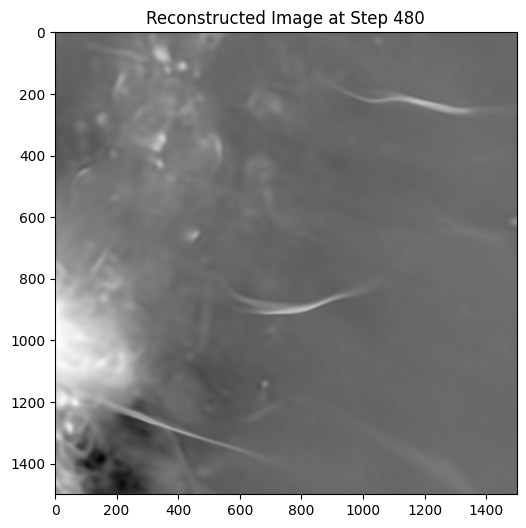

In [ ]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input_full, ground_truth_full = next(iter(dataloader))
model_input_full, ground_truth_full = model_input_full.cuda(), ground_truth_full.cuda()

# Determine the sidelength for visualization dynamically
sidelength_val = int(np.sqrt(model_input_full.shape[1]))

# Define batch size for processing during training loop
# The full image has 500*500 = 250000 pixels.
# Process in smaller batches to avoid OutOfMemoryError
batch_size_pixels = 4096 # Experiment with this value based on GPU memory. Adjust if still OOM.
num_pixels = model_input_full.shape[1]
num_batches = (num_pixels + batch_size_pixels - 1) // batch_size_pixels # Ceiling division

for step in range(total_steps):
    optim.zero_grad() # Zero gradients for the entire image pass

    current_loss = 0.0

    # Iterate over mini-batches of pixels
    for i in range(num_batches):
        start_idx = i * batch_size_pixels
        end_idx = min((i + 1) * batch_size_pixels, num_pixels)

        # Extract batch of coordinates and ground truth
        batch_model_input = model_input_full[:, start_idx:end_idx, :]
        batch_ground_truth = ground_truth_full[:, start_idx:end_idx, :]

        # Forward pass for the current batch
        # `coords` returned by img_siren is just `batch_model_input` cloned with requires_grad=True
        model_output_batch, _ = img_siren(batch_model_input)

        # Calculate loss for the current batch
        loss = ((model_output_batch - batch_ground_truth)**2).mean()

        # Accumulate gradients (loss.backward() adds to existing gradients)
        loss.backward() # Gradients are accumulated across batches before a single optim.step()

        current_loss += loss.item() * (end_idx - start_idx) # Accumulate weighted loss for overall average

    optim.step() # Update model parameters using accumulated gradients
    current_loss /= num_pixels # Average loss over all pixels processed in this step

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, current_loss))

        # For visualization, reconstruct the full image by processing in batches without gradient tracking
        with torch.no_grad():
            # Initialize a tensor to store the full reconstructed image
            full_model_output = torch.empty_like(ground_truth_full)
            for i in range(num_batches):
                start_idx = i * batch_size_pixels
                end_idx = min((i + 1) * batch_size_pixels, num_pixels)
                batch_model_input = model_input_full[:, start_idx:end_idx, :]
                batch_output, _ = img_siren(batch_model_input)
                full_model_output[:, start_idx:end_idx, :] = batch_output # Fill the reconstructed tensor

            fig, axes = plt.subplots(1,1, figsize=(6,6)) # Only one subplot for the reconstructed image
            axes.imshow(full_model_output.cpu().view(sidelength_val, sidelength_val).detach().numpy(), cmap='gray') # Added cmap='gray' for single-channel image
            axes.set_title(f"Reconstructed Image at Step {step}")
            plt.show()